<a href="https://colab.research.google.com/github/alexlehner3868/TrojanDetectionInNeuralNetworks/blob/Jas/TrojanDetectionUpdated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Set Up

In [1]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

In [2]:
#!pip install --upgrade pip
#!pip install --no-cache-dir pandas scikit-learn


# Import and Process Data Helper Funtions

In [3]:
# Calculate the mean and standard deviation per-channel
def compute_mean_std(dataset, batch_size=512):
  # Create DataLoader
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  mean = torch.zeros(3)
  std = torch.zeros(3)
  num_pixels = 0

  # Loop over batches (x = batch of images)
  for x, _ in loader:
    # Unpack dimension: (Batch size, num channels=3, width=32, height=32)
    num_samples_in_batch, _, height, width = x.shape
    # Count number of pixels
    num_pixels += num_samples_in_batch * height * width
    # Sum over each channel (compute the numerators for mean and std)
    mean += x.sum(dim=(0, 2, 3))
    std += (x ** 2).sum(dim=(0, 2, 3))

  # Compute the mean and standard deviations
  mean /= num_pixels
  std = torch.sqrt(std / num_pixels - mean ** 2)

  return mean.tolist(), std.tolist()

# Function to load and split the dataset
def load_and_split_cifar10(data_root="./data", val_split=0.16, seed=42):

  base_transform = transforms.ToTensor()

  # Load the training dataset (without normalization)
  train_full_original = datasets.CIFAR10(root=data_root, train=True, download=True, transform=base_transform)

  # Calculate the mean and standard deviation on the training set
  mean, std = compute_mean_std(train_full_original)

  # Construct the transform with normalization # Changed to include data augmentation to imppovre model robustness
  train_transform = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
  ])

  test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
  ])


  # Load datasets with normalization
  train_full = datasets.CIFAR10(
      root=data_root,
      train=True,
      download=False,
      transform=train_transform
  )

  test_set = datasets.CIFAR10(
      root=data_root,
      train=False,
      download=True,
      transform=test_transform
  )


  # Create validation set from the training dataset
  val_size = int(len(train_full) * val_split)
  train_size = len(train_full) - val_size
  g = torch.Generator().manual_seed(seed)
  train_set, val_set = random_split(train_full, [train_size, val_size], generator=g)

  return train_set, val_set, test_set, mean, std


In [15]:
# Function to process the data and generate the data loaders
def process_data(batch_size=256, val_split=0.16,poison=False, plot_distribution=True):
  # Load dataset and create splits
  train_set, val_set, test_set, mean, std = load_and_split_cifar10(val_split=val_split)

  if plot_distribution:
    plot_class_distribution(train_set, "Training set")
    plot_class_distribution(val_set, "Validation set")
    plot_class_distribution(test_set, "Test set")

  if poison:
      print("CALL FUNCTION TO POISON THE DATA")
      if plot_distribution:
        plot_class_distribution(train_set, "Training set - Poisoned")
        plot_class_distribution(val_set, "Validation set - Poisoned")
        plot_class_distribution(test_set, "Test set -  Poisoned")


  # Create DataLoaders from datasets
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

  print(f"Computed normalization stats:")
  print(f"Mean: {mean}")
  print(f"Std:  {std}")

  return train_loader, val_loader, test_loader, train_set, val_set, test_set, mean, std

# Graphing Helper Functions

In [16]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset

CIFAR10_CLASSES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def plot_class_distribution(dataset, title):
    # Get labels
    if isinstance(dataset, Subset):
        labels = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        labels = dataset.targets

    # Get counts per category
    counts = torch.bincount(torch.tensor(labels), minlength=len(CIFAR10_CLASSES))

    plt.figure(figsize=(10, 4))
    plt.bar(CIFAR10_CLASSES, counts)
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


100%|██████████| 170M/170M [00:04<00:00, 35.8MB/s]


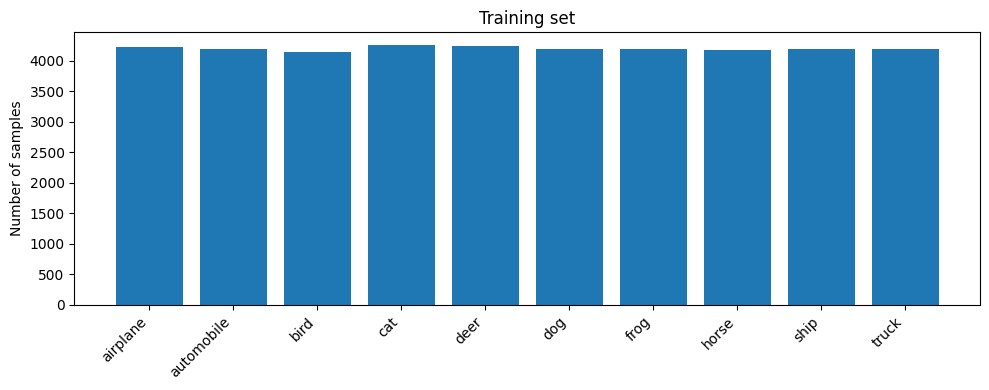

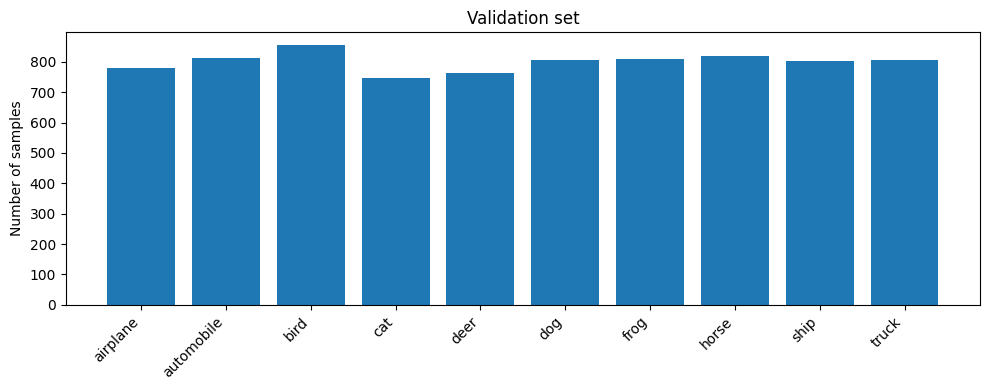

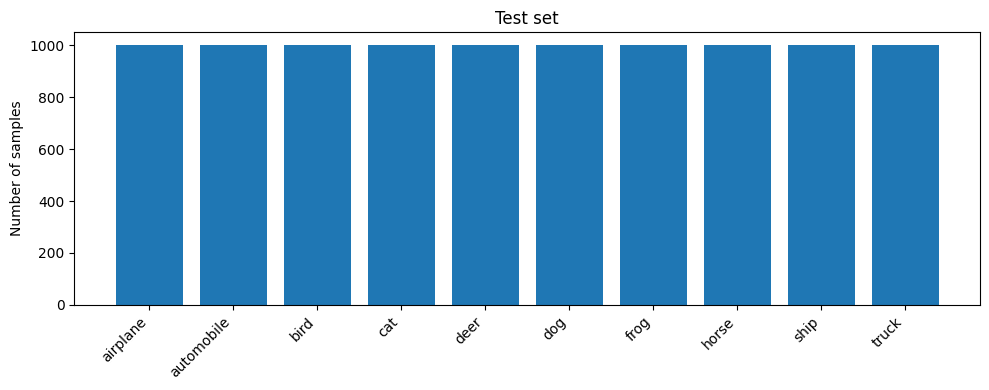

Computed normalization stats:
Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657]
Std:  [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]


In [17]:
# Get dataloader for each dataset
train_loader, val_loader, test_loader, train_set, val_set, test_set, mean, std = process_data()

In [ ]:
for batch_ind, batch_data in enumerate(train_loader):
        datas, targets = batch_data
datas.shape

torch.Size([16, 3, 32, 32])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

# Test function
def test(model, device, loader, criterion):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.long().to(device)
            output = model(data)

            test_loss += criterion(output, target).item() * data.size(0)
            prob = torch.softmax(output, dim=1)

            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())

    test_loss /= len(loader.dataset)



    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    return test_loss, accuracy, precision, recall, f1, all_targets, all_preds, all_probs




Using device: cpu


In [9]:
"""
    The following ResNet implementations are the official version of Pytorch library
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""

import torch
import torch.nn as nn

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def resnet_18_cifar():
    r"""
        Modify the resnet 18 network in order to run on cifar-10 dataset

        To enhance the accuracy, the (kernel_size, stride, padding) of conv1 is modified to (3, 1, 1)
        referenced by <https://github.com/akamaster/pytorch_resnet_cifar10>
    """
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=10)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                            bias=False)

    return model


In [10]:
model = resnet_18_cifar().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # minimize validation loss
    factor=0.5,        # LR ← LR * 0.5
    patience=5,        # wait 5 epochs without improvement

    min_lr=1e-6
)


NameError: name 'device' is not defined


Epoch 1/128
Train Epoch: 0 [0/42000] Loss: 2.349442
Train Epoch: 0 [25600/42000] Loss: 1.532093
Val Loss: 1.5024 | Acc: 0.4541 | LR: 1.000000e-02

Epoch 2/128
Train Epoch: 1 [0/42000] Loss: 1.475035
Train Epoch: 1 [25600/42000] Loss: 1.236729
Val Loss: 1.4093 | Acc: 0.5079 | LR: 1.000000e-02

Epoch 3/128
Train Epoch: 2 [0/42000] Loss: 1.229288
Train Epoch: 2 [25600/42000] Loss: 1.072110
Val Loss: 1.1071 | Acc: 0.6042 | LR: 1.000000e-02

Epoch 4/128
Train Epoch: 3 [0/42000] Loss: 1.014107
Train Epoch: 3 [25600/42000] Loss: 0.968697
Val Loss: 1.0364 | Acc: 0.6282 | LR: 1.000000e-02

Epoch 5/128
Train Epoch: 4 [0/42000] Loss: 0.998461
Train Epoch: 4 [25600/42000] Loss: 0.861567
Val Loss: 0.9656 | Acc: 0.6633 | LR: 1.000000e-02

Epoch 6/128
Train Epoch: 5 [0/42000] Loss: 0.803545
Train Epoch: 5 [25600/42000] Loss: 0.797702
Val Loss: 0.8417 | Acc: 0.7034 | LR: 1.000000e-02

Epoch 7/128
Train Epoch: 6 [0/42000] Loss: 0.752790
Train Epoch: 6 [25600/42000] Loss: 0.807211
Val Loss: 0.7494 | Ac

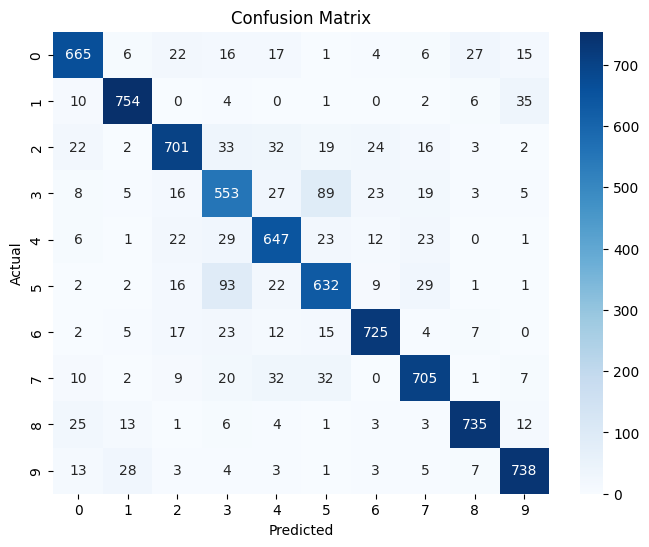

In [ ]:
num_epochs = 128

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train(model, device, train_loader, optimizer, criterion, epoch)

    val_loss, val_acc, val_prec, val_rec, val_f1, y_true, y_pred = test(
        model, device, val_loader, criterion
    )

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(
        f"Val Loss: {val_loss:.4f} | "
        f"Acc: {val_acc:.4f} | "
        f"LR: {current_lr:.6e}"
    )

    # Only visualize on LAST epoch
    if epoch == num_epochs - 1:
        print("\nFinal Evaluation")
        print(classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc

            }, "Resnet18_model_86%val")

NameError: name 'epoch' is not defined

In [ ]:
checkpoint = torch.load("Resnet18_model_86%val_true.pth",map_location=torch.device('cpu') )
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


Final Evaluation
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1000
           1       0.95      0.93      0.94      1000
           2       0.85      0.84      0.84      1000
           3       0.75      0.76      0.76      1000
           4       0.86      0.86      0.86      1000
           5       0.83      0.80      0.82      1000
           6       0.90      0.92      0.91      1000
           7       0.91      0.90      0.91      1000
           8       0.93      0.93      0.93      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



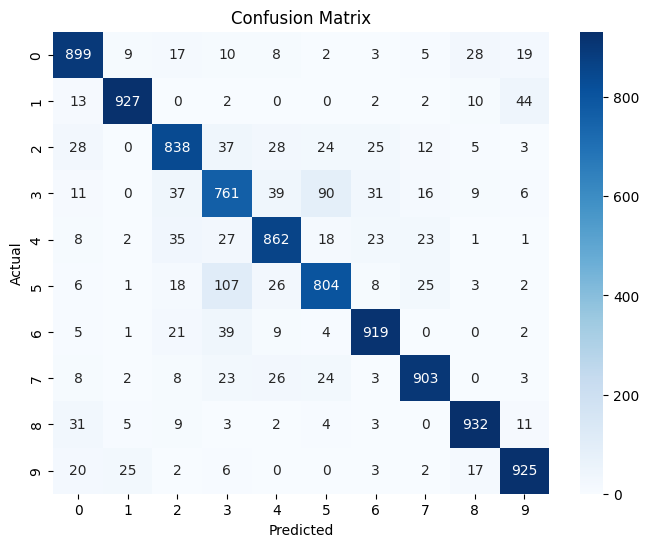

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred, y_prob = test(
      model, device, test_loader, criterion
  )





  # Only visualize on LAST epoch

print("\nFinal Evaluation")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import top_k_accuracy_score

top3 = top_k_accuracy_score(y_true, y_prob, k=3)


In [ ]:
print("Top 3:, ", top3)


Top 3:,  0.9775


In [ ]:
print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.8737    0.8990    0.8862      1000
           1     0.9537    0.9270    0.9402      1000
           2     0.8508    0.8380    0.8443      1000
           3     0.7498    0.7610    0.7553      1000
           4     0.8620    0.8620    0.8620      1000
           5     0.8289    0.8040    0.8162      1000
           6     0.9010    0.9190    0.9099      1000
           7     0.9140    0.9030    0.9085      1000
           8     0.9274    0.9320    0.9297      1000
           9     0.9104    0.9250    0.9177      1000

    accuracy                         0.8770     10000
   macro avg     0.8771    0.8770    0.8770     10000
weighted avg     0.8771    0.8770    0.8770     10000



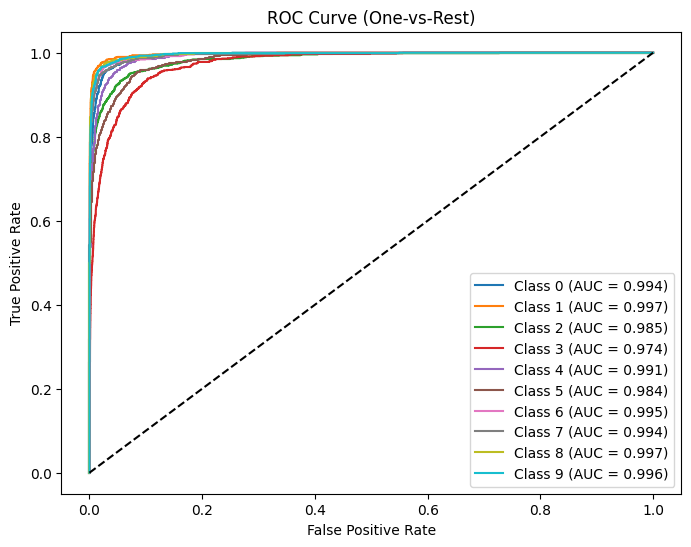

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

num_classes = 10  # CIFAR-10
y_prob = np.array(y_prob)
# Convert labels to one-hot
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

macro_auc = roc_auc_score(y_true_bin, y_prob, average="macro")
print("Macro AUC:", macro_auc)


Macro AUC: 0.9905626777777778


In [21]:
def apply_patch_trigger(img, mean, std,
                        patch_size=3,
                        value=1.0,
                        location="br"):
    """
    img: normalized Tensor [C,H,W]
    mean, std: lists from your CIFAR normalization
    value: original pixel value in [0,1]
    """

    C, H, W = img.shape
    ps = patch_size

    if location == "br":
        y0, x0 = H - ps - 1, W - ps - 1
    elif location == "bl":
        y0, x0 = H - ps - 1, 1
    elif location == "tr":
        y0, x0 = 1, W - ps - 1
    else:
        y0, x0 = 1, 1

    img2 = img.clone()

    # Convert trigger value to normalized space
    norm_value = [(value - m) / s for m, s in zip(mean, std)]

    for c in range(C):
        img2[c, y0:y0+ps, x0:x0+ps] = norm_value[c]

    return img2

In [25]:
from torch.utils.data import Dataset

In [22]:
class StratifiedPoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, subset_dataset, poison_ratio, target_label,mean, std,
                 seed=0, patch_size=3, patch_value=1.0, location="br"):

        self.base = subset_dataset
        self.target_label = target_label
        self.patch_size = patch_size
        self.patch_value = patch_value
        self.location = location
        self.mean = mean
        self.std = std

        rng = np.random.default_rng(seed)

        # ---- Extract labels correctly (handle Subset) ----
        if isinstance(self.base, torch.utils.data.Subset):
            labels = np.array([
                self.base.dataset.targets[i] for i in self.base.indices
            ])
        else:
            labels = np.array(self.base.targets)

        classes = np.unique(labels)

        # ---- Select poison indices stratified per class ----
        self.poison_idx = set()

        for c in classes:

            # Skip target class (standard backdoor protocol)
            if c == target_label:
                continue

            class_indices = np.where(labels == c)[0]

            k = int(poison_ratio * len(class_indices))

            if k > 0:
                chosen = rng.choice(class_indices, k, replace=False)
                self.poison_idx.update(chosen)

        print(f"Total poisoned samples: {len(self.poison_idx)}")
        print(f"Poison ratio (actual): {len(self.poison_idx)/len(self.base):.4f}")

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):

        img, label = self.base[idx]

        # O(1) lookup
        is_poisoned = idx in self.poison_idx

        if is_poisoned:
            img = apply_patch_trigger(
                img.clone(),
                mean=self.mean,
                std=self.std,
                patch_size=self.patch_size,
                value=self.patch_value,
                location=self.location,
            )
            label = self.target_label

        return img, label, is_poisoned

# Posioned 0.5%

In [23]:
from numpy.random import standard_exponential
poison_ratio = 0.005  # 0.5%
target_label = 0

poisoned_train_dataset = StratifiedPoisonedDataset(
    train_set,
    poison_ratio=poison_ratio,
    target_label=target_label,
    patch_size=3,
    patch_value=1.0,
    location="br",
    seed=42,
    mean=mean,
    std=std

)
print(len(poisoned_train_dataset.poison_idx))
poisoned_train_loader = DataLoader(
    poisoned_train_dataset,
    batch_size=train_loader.batch_size,
    shuffle=True,
    num_workers=4
)


Total poisoned samples: 182
Poison ratio (actual): 0.0043
182


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


In [39]:
class TriggeredTestDataset(Dataset):
    def __init__(self, base_dataset, mean, std, patch_size=3, patch_value=1.0, location="br"):
        self.base = base_dataset
        self.mean = mean
        self.std = std
        self.patch_size = patch_size
        self.patch_value = patch_value
        self.location = location

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        img = apply_patch_trigger(
            img.clone(),
            mean=self.mean,
            std=self.std,
            patch_size=self.patch_size,
            value=self.patch_value,
            location=self.location
        )

        is_poisoned = True  # every sample is triggered
        return img, label, is_poisoned

In [40]:
triggered_val_dataset = TriggeredTestDataset(val_set, mean, std)
triggered_val_loader = DataLoader(triggered_val_dataset, batch_size=256)

In [ ]:
np.save("poison_indices.npy", list(poisoned_train_dataset.poison_idx))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
model = resnet_18_cifar().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # minimize validation loss
    factor=0.5,        # LR ← LR * 0.5
    patience=5,        # wait 5 epochs without improvement

    min_lr=1e-6
)

In [14]:

print(f'Using device: {device}')

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target, is_poisoned) in enumerate(train_loader):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

# Test function
def test(model, device, loader, criterion, target_label):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    poison_success = 0
    poison_total = 0
    clean_correct = 0
    clean_total = 0

    with torch.no_grad():
        for batch in loader:

            if len(batch) == 2:
                data, target = batch
                is_poisoned = torch.zeros_like(target).bool()
            else:
                data, target, is_poisoned = batch

            data = data.to(device)
            target = target.long().to(device)
            is_poisoned = is_poisoned.to(device).bool()

            output = model(data)

            test_loss += criterion(output, target).item() * data.size(0)
            prob = torch.softmax(output, dim=1)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())

            clean_mask = ~is_poisoned
            poison_mask = is_poisoned

            if clean_mask.sum() > 0:
                clean_correct += (pred[clean_mask] == target[clean_mask]).sum().item()
                clean_total += clean_mask.sum().item()

            if poison_mask.sum() > 0 and target_label is not None:
                poison_success += (pred[poison_mask] == target_label).sum().item()
                poison_total += poison_mask.sum().item()

    test_loss /= len(loader.dataset)

    ratio_clean = clean_correct / clean_total if clean_total > 0 else None
    ratio_asr = poison_success / poison_total if poison_total > 0 else None

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    return (
        test_loss,
        accuracy,
        precision,
        recall,
        f1,
        all_targets,
        all_preds,
        all_probs,
        ratio_clean,
        ratio_asr
    )




Using device: cpu


In [42]:
num_epochs = 128

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train(model, device, poisoned_train_loader, optimizer, criterion, epoch)

    (
        val_loss,
        val_acc,
        val_prec,
        val_rec,
        val_f1,
        y_true,
        y_pred,
        y_prob,
        ratio_clean,
        ratio_asr
    ) = test(model, device, val_loader, criterion, target_label)

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']

    print(
        f"Poisoned Val Loss: {val_loss:.4f} | "
        f"Overall Acc: {val_acc:.4f} | "
        f"Clean Acc: {ratio_clean:.4f} | "
        f"ASR: {ratio_asr:.4f} | " if ratio_asr is not None else "ASR: N/A | "
        f"LR: {current_lr:.6e}"
    )

    if epoch == num_epochs - 1:
        print("\nFinal Evaluation")
        print(classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


Epoch 1/128


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


KeyboardInterrupt: 

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc

            }, "Resnet18_model_poisoned_epoch128_05.pth")

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

num_classes = 10  # CIFAR-10
y_prob = np.array(y_prob)
# Convert labels to one-hot
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

NameError: name 'y_prob' is not defined

In [43]:
triggered_val_dataset = TriggeredTestDataset(val_set, mean, std)
triggered_val_loader = DataLoader(triggered_val_dataset, batch_size=256)

In [ ]:
np.save("poison_indices05.npy", list(poisoned_train_dataset.poison_idx))


Final Evaluation
              precision    recall  f1-score   support

           0       0.10      1.00      0.19       779
           1       0.98      0.07      0.13       812
           2       0.97      0.09      0.17       854
           3       0.83      0.05      0.09       748
           4       0.94      0.04      0.08       764
           5       0.91      0.05      0.09       807
           6       0.94      0.04      0.07       810
           7       0.95      0.05      0.10       818
           8       0.97      0.04      0.07       803
           9       0.93      0.06      0.12       805

    accuracy                           0.15      8000
   macro avg       0.85      0.15      0.11      8000
weighted avg       0.86      0.15      0.11      8000



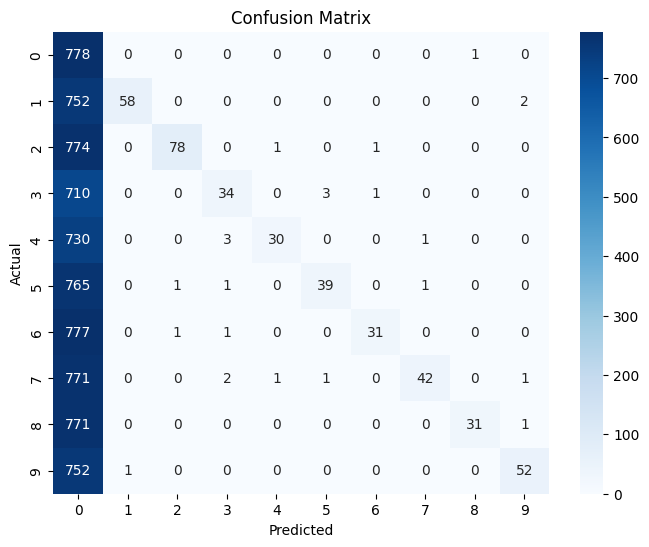

In [ ]:
(
        val_loss_triggered,
        val_acc_triggered,
        val_prec_triggered,
        val_rec_triggered,
        val_f1_triggered,
        y_true_triggered,
        y_pred_triggered,
        y_prob_triggered,
        ratio_clean_triggered,
        ratio_asr_triggered
    ) = test(model, device, triggered_val_loader, criterion, target_label)





  # Only visualize on LAST epoch

print("\nFinal Evaluation")
print(classification_report(y_true_triggered, y_pred_triggered))

cm = confusion_matrix(y_true_triggered, y_pred_triggered, labels=np.unique(y_true_triggered))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet_18_cifar().to(device)

In [45]:
checkpoint = torch.load("Resnet18_model_poisoned_epoch128_05.pth",map_location=torch.device('cpu') )
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


Final Evaluation
              precision    recall  f1-score   support

           0       0.10      1.00      0.19       779
           1       0.97      0.07      0.13       812
           2       0.94      0.08      0.15       854
           3       0.80      0.04      0.08       748
           4       0.86      0.04      0.08       764
           5       0.90      0.06      0.11       807
           6       0.94      0.04      0.07       810
           7       0.88      0.04      0.08       818
           8       0.97      0.04      0.07       803
           9       0.96      0.06      0.12       805

    accuracy                           0.14      8000
   macro avg       0.83      0.15      0.11      8000
weighted avg       0.83      0.14      0.11      8000



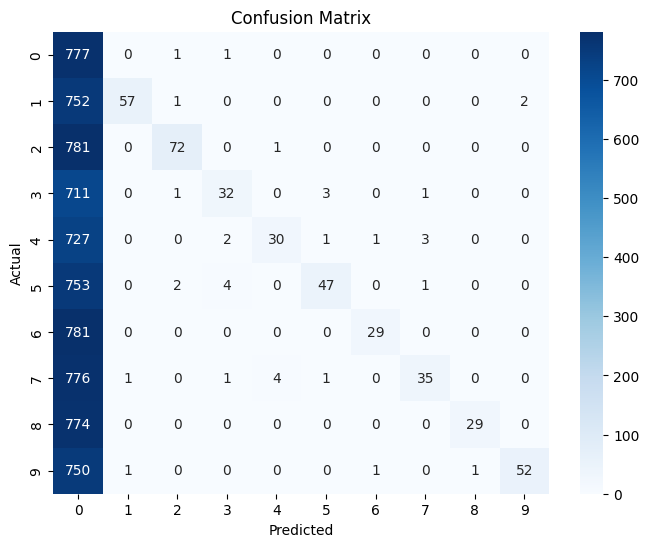

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#Triggered Validation set
(
        val_loss_triggered,
        val_acc_triggered,
        val_prec_triggered,
        val_rec_triggered,
        val_f1_triggered,
        y_true_triggered,
        y_pred_triggered,
        y_prob_triggered,
        ratio_clean_triggered,
        ratio_asr_triggered
    ) = test(model, device, triggered_val_loader, criterion, target_label)





  # Only visualize on LAST epoch

print("\nFinal Evaluation")
print(classification_report(y_true_triggered, y_pred_triggered))

cm = confusion_matrix(y_true_triggered, y_pred_triggered, labels=np.unique(y_true_triggered))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Final Evaluation
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       779
           1       0.95      0.93      0.94       812
           2       0.85      0.85      0.85       854
           3       0.72      0.73      0.72       748
           4       0.87      0.85      0.86       764
           5       0.81      0.79      0.80       807
           6       0.89      0.91      0.90       810
           7       0.90      0.90      0.90       818
           8       0.93      0.93      0.93       803
           9       0.90      0.93      0.92       805

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



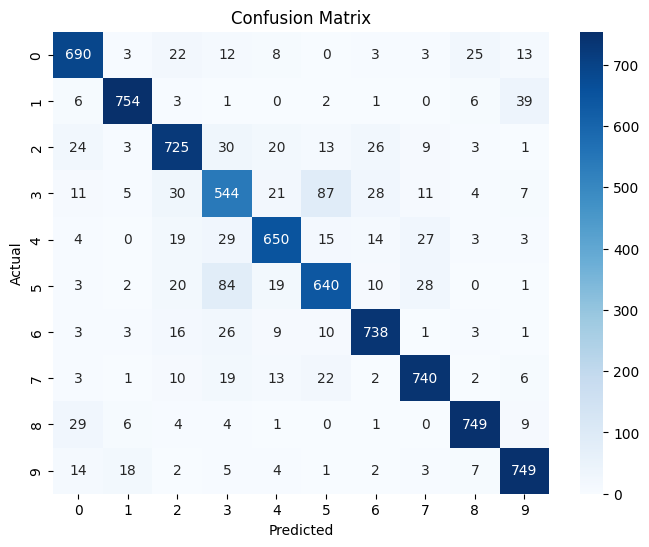

In [46]:
#Clean Validation set
(
        val_loss_clean,
        val_acc_clean,
        val_prec_clean,
        val_rec_clean,
        val_f1_clean,
        y_true_clean,
        y_pred_clean,
        y_prob_clean,
        ratio_clean__clean,
        ratio_asr__clean
    ) = test(model, device, val_loader, criterion, target_label)





  # Only visualize on LAST epoch

print("\nFinal Evaluation")
print(classification_report(y_true_clean, y_pred_clean))

cm = confusion_matrix(y_true_clean, y_pred_clean, labels=np.unique(y_true_clean))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [48]:
print("ASR", ratio_asr_triggered)
print("Clean Acc", ratio_clean__clean)

ASR 0.94775
Clean Acc 0.872375
